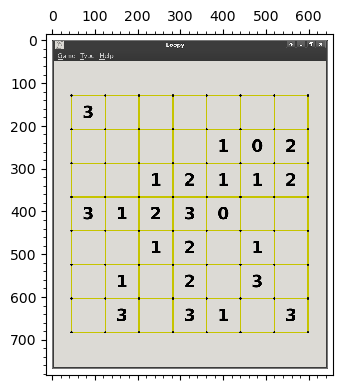

In [1]:
import pylab
I = pylab.imread('loopy1.png')
show(matrix_plot(I))

In [2]:
matrix_plot(I[127:685,42:602])

In [3]:
Nrows = 7
Ncols = 7

#Hints
hints = [
 (0,0,3), 
 (1,4,1), (1,5,0), (1,6,2),
 (2,2,1), (2,3,2), (2,4,1), (2,5,1), (2,6,2),
 (3,0,3), (3,1,1), (3,2,2), (3,3,3), (3,4,0),
 (4,2,1), (4,3,2), (4,5,1),
 (5,1,1), (5,3,2), (5,5,3),
 (6,1,3), (6,3,3), (6,4,1), (6,6,3)
]

EASY1 = hints
Easy1Image = pylab.imread('loopy1.png'),127,42,685,602

In [9]:
import numpy

def LoopyMILP(hints):    
    p = MixedIntegerLinearProgram(maximization=True, solver = "GLPK")
    #w[j,k] = 1 sii hay lado horizontal orientacion west entre j,k y j,k+1, etc
    w,n,e,s = [p.new_variable(binary=True) for _ in range (4)]
    edges = {'W':w, 'N':n, 'E':e, 'S':s}
    #nw[j,k] = 1 sii el nodo en la posicion j,k es de tipo North West, etc
    nw,ns,ne,ws,we,wn,se,sn,sw,en,ew,es = [p.new_variable(binary=True) for _ in range(12)]
    #c[j,k]=1 sii la celda j,k esta en el interior de la curva
    c = p.new_variable(binary=True)
    vertices = {'NW':nw,'NS':ns,'NE':ne,
              'WS':ws,'WE':we,'WN':wn,
              'SE':se,'SN':sn,'SW':sw,
              'EN':en,'EW':ew,'ES':es}
    
    def lados_salientes(j,k):
        vs = {}
        vs['W'] = w[j,k] if k<Ncols else None
        vs['E'] = e[j,k-1] if k>0 else None
        vs['S'] = s[j,k] if j<Nrows else None
        vs['N'] = n[j-1,k] if j>0 else None
        return vs

    def lados_entrantes(j,k):
        vs = {}
        vs['W'] = e[j,k] if k<Ncols else None
        vs['E'] = w[j,k-1] if k>0 else None
        vs['S'] = n[j,k] if j<Nrows else None
        vs['N'] = s[j-1,k] if j>0 else None
        return vs

    #Cada lado solo puede estar una vez, con una u otra orientacion
    for j in range(Nrows):
        for k in range(Ncols):
            p.add_constraint(w[j,k]+e[j,k]<=1)
            p.add_constraint(n[j,k]+s[j,k]<=1)

    #Hints
    for j,k,m in hints:
        p.add_constraint(
             w[j,k]+w[j+1,k]+e[j,k]+e[j+1,k]+
             s[j,k]+s[j,k+1]+n[j,k]+n[j,k+1]==m)

    #Cada vertice tiene a lo sumo un tipo
    for j in range(Nrows +1):
        for k in range(Ncols+1):
            p.add_constraint(sum(type[j,k] for type in vertices.values())<=1)

    #Cada tipo de nodo limita los lados contiguos
    for j in range(Nrows +1):
        for k in range(Ncols+1):
            lout = lados_salientes(j,k)
            lin  = lados_entrantes(j,k)
            for ls,pos in ((lin,0),(lout,1)):
                for dir,var in ls.items():
                    p.add_constraint(sum(
                            type[j,k]
                            for adjacent_edges,type in vertices.items()
                            if dir==adjacent_edges[pos]
                        ) == (var if var is not None else 0)
                    )

    #Interior-Exterior
    #South - North
    for j in range(Nrows):
        p.add_constraint(s[j,0]==c[j,0])
        p.add_constraint(n[j,0]==0)
        p.add_constraint(s[j,Ncols]==0)
        p.add_constraint(n[j,Ncols]==c[j,Ncols-1])
        for k in range(1,Ncols):
            p.add_constraint(c[j,k+1] -c[j,k] == s[j,k+1] - n[j,k+1])
    #East - West
    for k in range(Ncols):
        p.add_constraint(e[0,k]==c[0,k])
        p.add_constraint(e[Nrows,k]==0)
        p.add_constraint(w[0,k]==0)
        p.add_constraint(w[Nrows,k]==c[Nrows-1,k])
        for k in range(1,Ncols):
            p.add_constraint(c[j+1,k] -c[j,k] == e[j+1,k] - w[j+1,k])

    #One loop only
    p.add_constraint(sum( nw[j,k]+ws[j,k]+se[j,k]+en[j,k]-
                         (wn[j,k]+sw[j,k]+es[j,k]+ne[j,k])
                         for j in range(Nrows+1) for k in range(Ncols+1)) == 4)

    p.set_objective(
        sum(n[j,k]+w[j,k]+s[j,k]+e[j,k] for j in range(Nrows) for k in range(Ncols))
    )
    return vertices,edges,p

In [10]:
%%time
vertices,edges,p = LoopyMILP(hints)
#print (p.show())
print(p.solve())

45.0
CPU times: user 134 ms, sys: 0 ns, total: 134 ms
Wall time: 137 ms


In [13]:
from collections import defaultdict

w0,s0,e0,n0 = [defaultdict(int,p.get_values(edges[l])) for l in 'WSEN']
for l,v in edges.items():
    print (l)
    v0 = defaultdict(int,p.get_values(v))
    for j in range(Nrows+1):
        for k in range(Ncols+1):
            if v0[j,k]:
                if l=='W':
                    print ('there is a horizontal edge from (%d,%d) to (%d,%d)'%(j,k,j,k+1))
                if l=='E':
                    print ('there is a horizontal edge from (%d,%d) to (%d,%d)'%(j,k+1,j,k))
                if l=='S':
                    print ('there is a vertical edge from (%d,%d) to (%d,%d)'%(j,k,j+1,k))
                if l=='N':
                    print ('there is a vertical edge from (%d,%d) to (%d,%d)'%(j+1,k,j,k))

W
there is a horizontal edge from (1,0) to (1,1)
there is a horizontal edge from (1,2) to (1,3)
there is a horizontal edge from (1,3) to (1,4)
there is a horizontal edge from (2,6) to (2,7)
there is a horizontal edge from (4,0) to (4,1)
there is a horizontal edge from (4,3) to (4,4)
there is a horizontal edge from (5,5) to (5,6)
there is a horizontal edge from (5,6) to (5,7)
there is a horizontal edge from (6,0) to (6,1)
there is a horizontal edge from (7,1) to (7,2)
there is a horizontal edge from (7,3) to (7,4)
there is a horizontal edge from (7,4) to (7,5)
there is a horizontal edge from (7,5) to (7,6)
there is a horizontal edge from (7,6) to (7,7)
N
there is a vertical edge from (1,7) to (0,7)
there is a vertical edge from (2,2) to (1,2)
there is a vertical edge from (2,7) to (1,7)
there is a vertical edge from (3,2) to (2,2)
there is a vertical edge from (3,6) to (2,6)
there is a vertical edge from (4,2) to (3,2)
there is a vertical edge from (4,6) to (3,6)
there is a vertical edg

In [15]:
I, Ox, Oy, Ex, Ey = Easy1Image
Dx,Dy = int((Ex-Ox)/Nrows), int((Ey-Oy)/Ncols)
width = 5
def subsliceH(j,k):
    return (slice(Ox+j*Dx,Ox+j*Dx+width), 
            slice(Oy+k*Dy,Oy+(k+1)*Dy),
            slice(0,4))

def subsliceV(j,k):
    return (slice(Ox+j*Dx,Ox+(j+1)*Dx), 
            slice(Oy+k*Dy,Oy+k*Dy+width),
            slice(0,4))

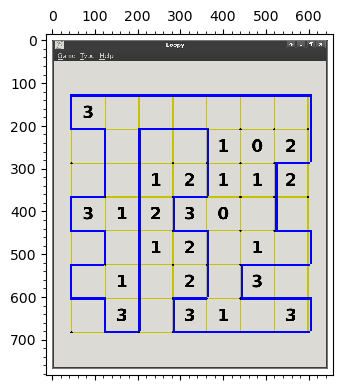

In [16]:
import numpy
blue = numpy.array([[[0,0,1,1]]])
sol_image = I.copy()
for j in range(Nrows+1):
    for k in range(Ncols+1):
        if w0[j,k] or e0[j,k]:
            sol_image[subsliceH(j,k)] = blue
        if n0[j,k] or s0[j,k]:
            sol_image[subsliceV(j,k)] = blue
matrix_plot(sol_image).show()